# Import packages

In [1]:
# isort:imports-stdlib

# isort:import-localfolder


# isort:imports-thirdparty
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier

# isort:imports-firstparty
from data_loader.customer.v1 import DataLoader
from data_preprocessor.v1 import DataPreprocessor
from utils import ignore_warnings

# Notebook configuration

In [2]:
%load_ext autoreload
%autoreload 2
pd.set_option("display.float_format", lambda x: "%.3f" % x)
ignore_warnings()

# Load data

In [3]:
data_loader = DataLoader()
data = data_loader.load_data()

# Preprocess data

In [4]:
data_preprocessor = DataPreprocessor()

In [5]:
preprocessed_data = data_preprocessor.preprocess(data)
preprocessed_data

,row_id,user_id,length_mean,start_year_mean,start_yearday_mean,start_month_mean,start_monthday_mean,start_week_mean,start_weekday_mean,start_isweekend_mean,...,purchase_latent_factor9,purchase_latent_factor10,purchase_latent_factor11,purchase_latent_factor12,purchase_latent_factor13,purchase_latent_factor14,purchase_latent_factor15,purchase_latent_factor16,purchase_latent_factor17,churn
0,-1.731,-0.857,2.293,0.197,-0.016,-0.035,0.393,-0.056,0.173,0.094,...,-0.435,-0.438,-0.287,-0.711,0.234,1.391,-0.101,-0.338,-0.329,0
1,-1.730,0.155,-0.263,0.310,-0.236,-0.228,-0.146,-0.241,-0.110,-0.174,...,-0.435,3.252,0.028,-0.509,0.391,0.692,0.796,-0.338,-0.329,0
2,-1.730,0.494,-0.263,-0.793,0.610,0.544,1.395,0.667,-1.732,0.001,...,-0.104,1.047,-0.337,-0.646,1.554,-0.468,-0.381,-0.338,-0.329,1
3,-1.729,1.334,0.789,1.938,-1.536,-1.543,0.582,-1.447,-0.674,-0.508,...,-0.435,1.610,-0.337,-0.711,-0.087,0.018,-0.381,0.431,1.041,0
4,-1.728,-0.919,-0.263,0.181,-0.339,-0.319,-0.375,-0.276,-0.223,0.420,...,2.642,-0.438,-0.337,-0.711,-0.750,-0.468,-0.381,-0.110,-0.329,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112605,1.728,-0.973,-0.263,-0.793,0.387,0.505,-2.572,0.423,-3.134,2.463,...,-0.435,1.135,-0.337,-0.711,-0.649,0.619,-0.381,-0.338,-0.181,0
112606,1.728,-0.950,-0.262,-0.793,0.413,0.505,-2.005,0.500,-3.134,-1.845,...,-0.435,-0.438,-0.337,-0.468,-0.750,-0.468,-0.381,0.109,-0.329,0
112607,1.728,-0.852,-0.263,-0.793,0.438,0.505,-1.471,0.485,2.216,-1.845,...,-0.435,-0.438,-0.337,-0.711,-0.750,-0.468,-0.381,-0.338,-0.329,0
112608,1.730,-0.059,-0.263,-0.793,0.427,0.505,-1.707,0.490,-0.364,-0.670,...,3.901,-0.438,-0.337,-0.711,-0.750,-0.468,-0.381,-0.338,-0.329,0


# Train model

In [6]:
# Split the data into features and target
X = preprocessed_data.drop("churn", axis=1)
y = preprocessed_data["churn"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=5),
}

# Dictionary to store results
results = {model_name: {} for model_name in models.keys()}

In [7]:
# Train and evaluate models
for name, model in models.items():
    print(f"\n{name}:")

    # Cross-validation
    cv_scores = cross_val_score(
        model, X_train, y_train, cv=5, scoring="roc_auc")
    print(
        f"Cross-validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})"
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    results[name]["Accuracy"] = accuracy_score(y_test, y_pred)
    results[name]["Precision"] = precision_score(y_test, y_pred)
    results[name]["Recall"] = recall_score(y_test, y_pred)
    results[name]["F1 Score"] = f1_score(y_test, y_pred)
    results[name]["ROC AUC"] = roc_auc_score(y_test, y_pred_proba)

    for metric, value in results[name].items():
        print(f"{metric}: {value:.4f}")

    # Compute permutation feature importance
    perm_importance = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42
    )
    results[name]["Feature Importance"] = pd.DataFrame(
        {"Feature": X.columns, "Importance": perm_importance.importances_mean}
    ).sort_values("Importance", ascending=False)


Logistic Regression:
Cross-validation ROC AUC: 0.9873 (+/- 0.0018)
Accuracy: 0.9580
Precision: 0.9135
Recall: 0.8741
F1 Score: 0.8934
ROC AUC: 0.9876

Decision Tree:
Cross-validation ROC AUC: 0.9780 (+/- 0.0028)
Accuracy: 0.9527
Precision: 0.9553
Recall: 0.8024
F1 Score: 0.8722
ROC AUC: 0.9793


# Evaluate result

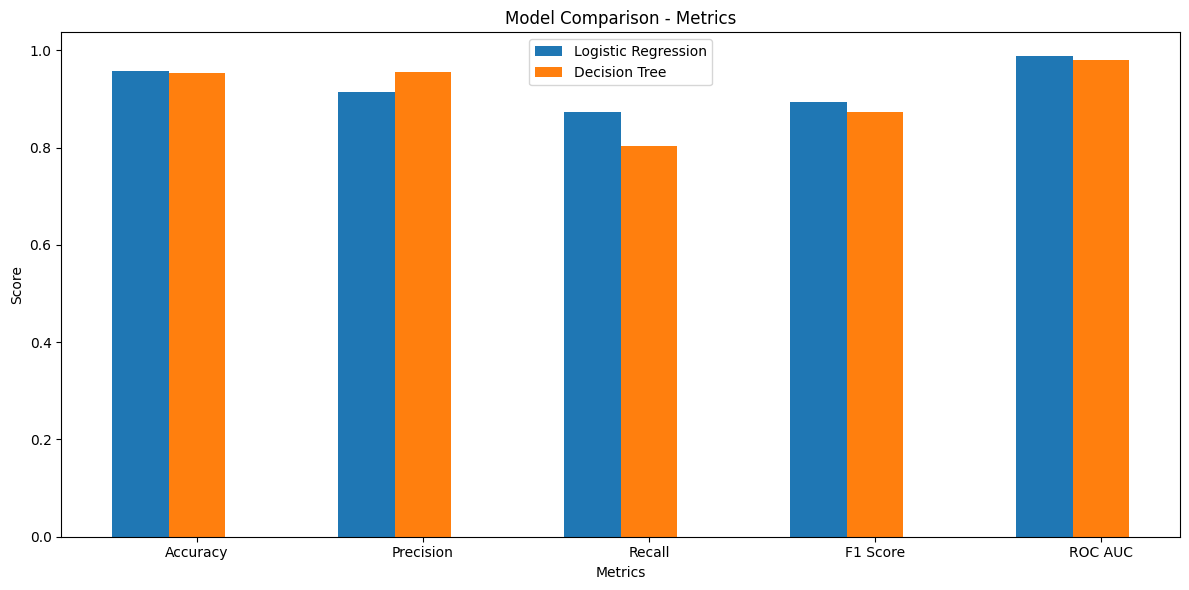

In [8]:
# Visualize metrics comparison
plt.figure(figsize=(12, 6))
metrics = list(results[list(results.keys())[0]].keys())[
    :-1
]  # Exclude 'Feature Importance'
x = np.arange(len(metrics))
width = 0.25

for i, (model_name, model_results) in enumerate(results.items()):
    plt.bar(x + i * width, [model_results[m]
            for m in metrics], width, label=model_name)

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Model Comparison - Metrics")
plt.xticks(x + width, metrics)
plt.legend()
plt.tight_layout()
plt.show()

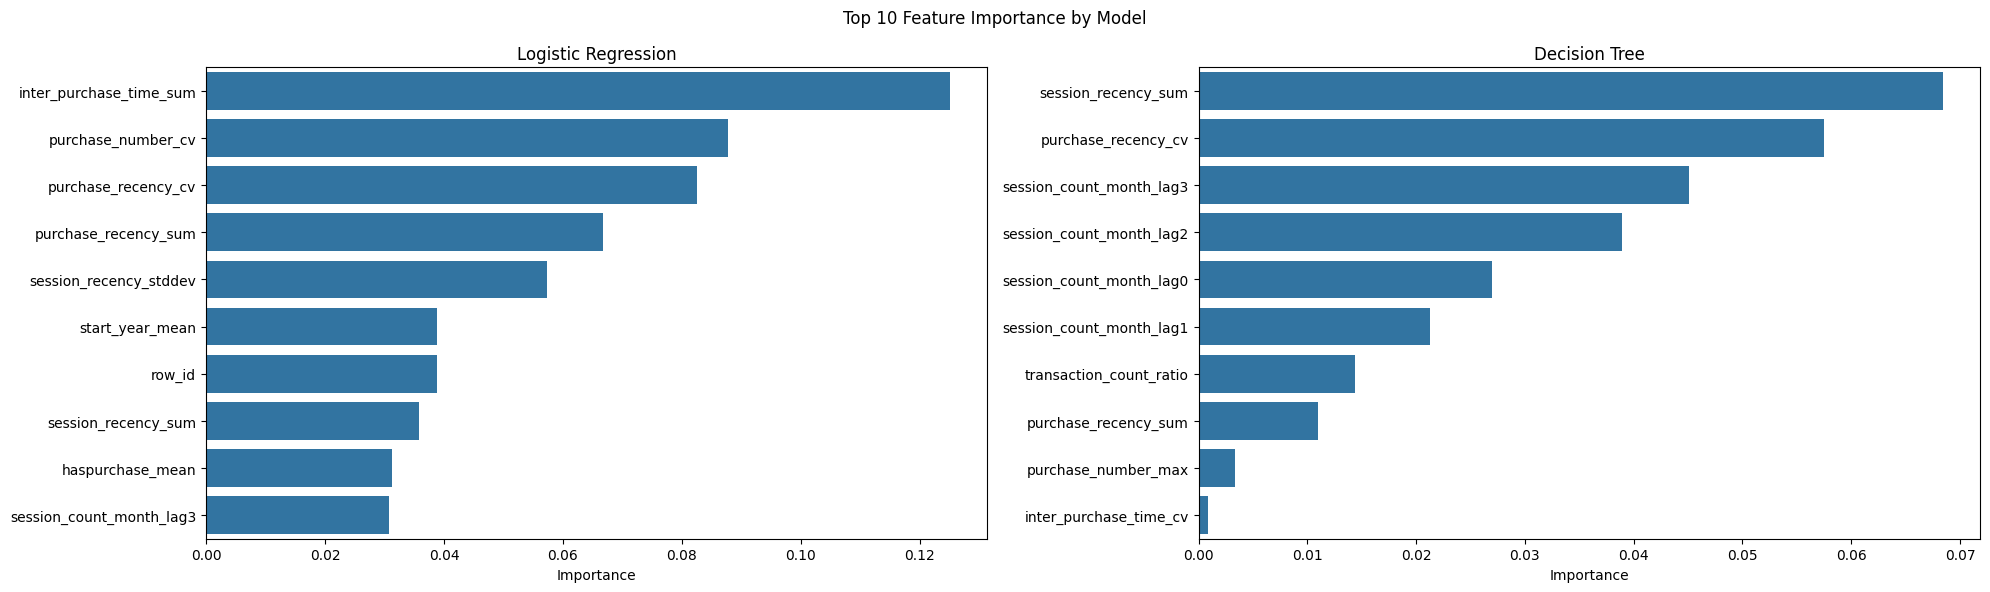

In [9]:
# Visualize feature importance for each model
n_features = 10  # Number of top features to show
fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
fig.suptitle("Top 10 Feature Importance by Model")

for ax, (model_name, model_results) in zip(axes, results.items()):
    feature_imp = model_results["Feature Importance"].head(n_features)
    sns.barplot(x="Importance", y="Feature", data=feature_imp, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()